# Proyecto Bimestral: Sistema de Recuperaci´on de Información basado en Reuters-21578
## 1. Introducción
El objetivo de este proyecto es diseñar, construir, programar y desplegar un Sistema de Recuperación de Información (SRI) utilizando el corpus Reuters-21578.
## 2. Fases del Proyecto
###  2.1. Adquisición de datos

*   Descargar el Corpus Reuters-21578
*   Descomprimir y organizar los archivos
*   Documentar el proceso de adquisición de datos

![Descripción de la imagen](images/corpus_reuters.jpg)

#### Descarga y análisis inicial del corpus

1. El archivo comprimido fue descargado y descomprimido en una carpeta local vinculada a un repositorio de GitHub.
2. Posteriormente, se analizó el contenido del corpus, obteniendo los siguientes resultados:
   - **Carpeta `test`**: Contiene 3019 archivos.
   - **Carpeta `training`**: Contiene 7769 archivos.
   - **Archivo `cats`**: Incluye las categorías.
   - **Archivo `readme`**: Proporciona información general sobre el corpus.
   - **Archivo `stopwords`**: Contiene una lista de palabras vacías.

#### Librerias y Dependencias necesarias

#### Notas

Al no encontrarnos en un entorno de Google Colab, sino en VS, nos basta con ejecutar una sola vez el comando `!pip install rarfile` para tener la biblioteca `rarfile` en nuestro entorno.

In [27]:
#!pip install rarfile

Al no encontrarnos en un entorno de Google Colab, sino en VS, nos basta con ejecutar una sola vez el comando `!pip install nltk` para tener la biblioteca `nltk` en nuestro entorno.

In [29]:
#!pip install nltk

El comando `pip install scikit-learn` instala la librería `scikit-learn`, que es una herramienta para realizar tareas de aprendizaje automático (machine learning) como clasificación, regresión y clustering.

In [17]:
#pip install scikit-learn

El comando `pip install gensim` instala la librería `gensim`, que se utiliza para el procesamiento de texto y la creación de modelos de aprendizaje automático, como Word2Vec, para generar representaciones vectoriales de palabras.

In [19]:
#pip install gensim

In [38]:
# Librerias necesarias
import os
import re
import nltk
import rarfile
import time # Evaluar tecnicas de vectorización
import psutil # Evaluar tecnicas de vectorización
import gc # Evaluar tecnicas de vectorización
import numpy as np
import pandas as pd # Obtener tablas
import matplotlib.pyplot as plt # Para obtener gráfica
import seaborn as sns # Para obtener gráfica
from collections import defaultdict # Para el indice invertido
from sklearn.preprocessing import normalize # para Word2Vec
from nltk.tokenize import word_tokenize # para tokenizar
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

### 2.2. Preprocesamiento

#### 2.2.1. Extraer el contenido relevante de los documentos

In [2]:
rarfile.UNRAR_TOOL = r"D:\UnRAR\UnRAR.exe" # Cambiar por ubicación local de tu herramienta UNRAR

# Ruta del archivo .rar
rar_path = 'material/reuters.rar'
output_dir = 'material/content'

# Crear el directorio de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Descomprimir el archivo .rar
with rarfile.RarFile(rar_path) as rf:
    rf.extractall(output_dir)

# Verificar que se haya descomprimido correctamente
print("Archivos extraídos:")
print(os.listdir(output_dir))

Archivos extraídos:
['reuters']


In [2]:
# Directorios de documentos
train_dir = 'material/content/reuters/training'
test_dir = 'material/content/reuters/test'
cats_file = 'material/content/reuters/cats.txt'

# Diccionario para almacenar documentos
documentos = {}

# Función para extraer contenido de un archivo de noticias
def extraer_texto(filepath):
    try:
        with open(filepath, 'r', encoding='latin-1') as file:
            contenido = file.read()
            texto_limpio = contenido.strip()  # Elimina espacios en blanco iniciales y finales
            return texto_limpio
    except Exception as e:
        print(f"Error al leer el archivo {filepath}: {e}")
        return ""

# Función para cargar las categorías de los documentos
def cargar_categorias(filepath):
    categorias = {}
    try:
        with open(filepath, 'r', encoding='latin-1') as file:
            for linea in file:
                partes = linea.strip().split()  # Divide la línea en partes separadas por espacios
                if len(partes) >= 2:
                    doc_id = partes[0]  # Primer elemento es el id del documento (test/14826, training/1)
                    etiquetas = partes[1:]  # Resto de elementos son categorías
                    categorias[doc_id] = etiquetas
    except Exception as e:
        print(f"Error al leer el archivo de categorías {filepath}: {e}")
    return categorias

# Función para cargar los documentos y asociar categorías
def cargar_documentos(directorio, tipo, categorias_dict):
    archivos = os.listdir(directorio)
    if not archivos:
        print(f"No se encontraron archivos en {directorio}")
    for archivo in archivos:
        filepath = os.path.join(directorio, archivo)
        doc_id = f"{tipo}/{archivo}"
        texto = extraer_texto(filepath)
        categorias = categorias_dict.get(doc_id, [])  # Obtener categorías, si no hay, devuelve lista vacía

        # Almacenar en el diccionario
        documentos[doc_id] = {
            "texto": texto,
            "categorias": categorias
        }

In [3]:
# Cargar categorías
categorias_dict = cargar_categorias(cats_file)

# Cargar documentos de entrenamiento y prueba
cargar_documentos(train_dir, 'training', categorias_dict)
cargar_documentos(test_dir, 'test', categorias_dict)

# Verificar el tamaño y algunas muestras
print(f"Total de documentos cargados: {len(documentos)}")
if documentos:
    ejemplo_doc = list(documentos.items())[0]
    print(f"ID: {ejemplo_doc[0]}")
    print(f"Texto: {ejemplo_doc[1]['texto'][:500]}...")  # Mostrar los primeros 500 caracteres
    print(f"Categorías: {ejemplo_doc[1]['categorias']}")
else:
    print("No se cargaron documentos.")

Total de documentos cargados: 10788
ID: training/1
Texto: BAHIA COCOA REVIEW
  Showers continued throughout the week in
  the Bahia cocoa zone, alleviating the drought since early
  January and improving prospects for the coming temporao,
  although normal humidity levels have not been restored,
  Comissaria Smith said in its weekly review.
      The dry period means the temporao will be late this year.
      Arrivals for the week ended February 22 were 155,221 bags
  of 60 kilos making a cumulative total for the season of 5.93
  mln against 5.81 at th...
Categorías: ['cocoa']


#### 2.2.2. Realizar limpieza de datos: eliminación de caracteres no deseados, normalización de texto, etc.

In [4]:
# Función para limpiar texto
def limpiar_texto(texto):
    # 1. Conversión a minúsculas
    texto = texto.lower()

    # 2. Eliminación de caracteres especiales y números
    texto = re.sub(r'[^a-z\s]', '', texto)

    # 3. Eliminación de espacios extra
    texto = re.sub(r'\s+', ' ', texto).strip()

    return texto

In [5]:
# Aplicar limpieza de texto a todos los documentos
for doc_id in documentos:
    texto_original = documentos[doc_id]['texto']
    texto_limpio = limpiar_texto(texto_original)

    # Actualizar el texto limpio en el diccionario
    documentos[doc_id]['texto'] = texto_limpio

# Verificar el resultado de la limpieza en un documento de ejemplo
ejemplo_doc = list(documentos.items())[0]
print(f"ID: {ejemplo_doc[0]}")
print(f"Texto limpio: {ejemplo_doc[1]['texto'][:500]}...")

ID: training/1
Texto limpio: bahia cocoa review showers continued throughout the week in the bahia cocoa zone alleviating the drought since early january and improving prospects for the coming temporao although normal humidity levels have not been restored comissaria smith said in its weekly review the dry period means the temporao will be late this year arrivals for the week ended february were bags of kilos making a cumulative total for the season of mln against at the same stage last year again it seems that cocoa delive...


#### 2.2.3. Tokenización: dividir el texto en palabras o tokens

#### Nota
Al no encontrarnos en un entorno de Google Colab, sino en VS, nos basta con ejecutar una sola vez el comando `nltk.download('punkt')` o `nltk.download('punkt_tab')`, por lo cual no es necesario volver a ejcutarlo.

In [6]:
# Descargar los recursos necesarios de NLTK para tokenizar texto en oraciones y palabras
#nltk.download('punkt')
#nltk.download('punkt_tab')

In [7]:
# Función para tokenizar texto
def tokenizar_texto(texto):
    # Utilizamos word_tokenize de NLTK para dividir en tokens
    tokens = word_tokenize(texto)
    return tokens

In [8]:
# Aplicar tokenización a todos los documentos
for doc_id in documentos:
    texto_limpio = documentos[doc_id]['texto']
    tokens = tokenizar_texto(texto_limpio)

    # Guardamos los tokens en el diccionario
    documentos[doc_id]['tokens'] = tokens

# Verificar el resultado de la tokenización en un documento de ejemplo
ejemplo_doc = list(documentos.items())[0]
print(f"ID: {ejemplo_doc[0]}")
print(f"Tokens: {ejemplo_doc[1]['tokens'][:20]}...")

ID: training/1
Tokens: ['bahia', 'cocoa', 'review', 'showers', 'continued', 'throughout', 'the', 'week', 'in', 'the', 'bahia', 'cocoa', 'zone', 'alleviating', 'the', 'drought', 'since', 'early', 'january', 'and']...


#### 2.2.4. Eliminar stop words y  aplicar stemming o lematización.

In [9]:
# Cargar el archivo de stopwords proporcionado
ruta_stopwords = 'material/content/reuters/stopwords'
stopwords_personalizadas = set()

with open(ruta_stopwords, 'r') as archivo:
    for linea in archivo:
        palabra = linea.strip()  # Removemos espacios y saltos de línea
        if palabra:  # Evitamos añadir líneas vacías
            stopwords_personalizadas.add(palabra.lower())

# Verificamos algunas stop words cargadas
print("Ejemplo de Stop Words cargadas:", list(stopwords_personalizadas)[:15])

Ejemplo de Stop Words cargadas: ['follows', 'the', 'lately', 'then', 'if', 'looking', 'moreover', 'went', 'go', "a's", "couldn't", 'is', 'whom', 'thorough', 'ie']


In [10]:
# Función para eliminar stop words de los tokens
def eliminar_stopwords(tokens, stopwords):
    # Filtramos los tokens que no están en la lista de stopwords
    tokens_filtrados = [token for token in tokens if token.lower() not in stopwords]
    return tokens_filtrados

# Aplicamos la eliminación de stop words a cada documento
for doc_id in documentos:
    tokens = documentos[doc_id]['tokens']
    tokens_sin_stopwords = eliminar_stopwords(tokens, stopwords_personalizadas)

    # Guardamos los tokens filtrados
    documentos[doc_id]['tokens'] = tokens_sin_stopwords

# Verificar el resultado después de eliminar stop words en un documento de ejemplo
ejemplo_doc = list(documentos.items())[0]
print(f"ID: {ejemplo_doc[0]}")
print(f"Tokens sin Stop Words: {ejemplo_doc[1]['tokens'][:20]}...")

ID: training/1
Tokens sin Stop Words: ['bahia', 'cocoa', 'review', 'showers', 'continued', 'week', 'bahia', 'cocoa', 'zone', 'alleviating', 'drought', 'early', 'january', 'improving', 'prospects', 'coming', 'temporao', 'normal', 'humidity', 'levels']...


#### Nota
Para nuestro caso de estudio y aplicación de este proyecto, aplicaremos **Steming**. 

Como equipo, consideramos más eficiente en términos de recursos porque el stemming utiliza reglas más simples y rápidas para reducir las palabras a su raíz, mientras que la lemmatización requiere un procesamiento más complejo y el uso de diccionarios para obtener la forma base correcta de las palabras.

In [11]:
# Inicializar el stemmer
stemmer = PorterStemmer()

# Función para aplicar stemming a los tokens de un documento
def aplicar_stemming(tokens):
    return [stemmer.stem(token) for token in tokens]

In [12]:
# Aplicamos el stemming a los tokens de cada documento
for doc_id in documentos:
    tokens = documentos[doc_id]['tokens']  # Obtiene los tokens del documento
    tokens_stemmed = aplicar_stemming(tokens)  # Aplica el stemming
    documentos[doc_id]['tokens'] = tokens_stemmed  # Guarda los tokens procesados

# Verificamos un documento de ejemplo después del stemming
ejemplo_doc = list(documentos.items())[0]
print(f"ID: {ejemplo_doc[0]}")
print(f"Tokens con Stemming: {ejemplo_doc[1]['tokens'][:20]}...")

ID: training/1
Tokens con Stemming: ['bahia', 'cocoa', 'review', 'shower', 'continu', 'week', 'bahia', 'cocoa', 'zone', 'allevi', 'drought', 'earli', 'januari', 'improv', 'prospect', 'come', 'temporao', 'normal', 'humid', 'level']...


### 2.3.  Representación de Datos en Espacio Vectorial

#### 2.3.1. Utilizar técnicas como Bag of Words (BoW), TF-IDF, y Word2Vec.

In [13]:
# Crear un objeto de CountVectorizer
vectorizer = CountVectorizer()

# Obtener las palabras de los documentos (usando los textos limpios después de eliminar stopwords y stemming)
documentos_texto = [" ".join(doc["tokens"]) for doc in documentos.values()]

# Ajustar el modelo y transformar los documentos
X_bow = vectorizer.fit_transform(documentos_texto)

# Mostrar las características (palabras)
print(f"Características (Palabras) BoW: {vectorizer.get_feature_names_out()[:10]}...")  # Mostrar las primeras 10 palabras

# Mostrar la matriz de términos de frecuencia
print(f"Forma de la matriz BoW: {X_bow.shape}")

Características (Palabras) BoW: ['aa' 'aaa' 'aabex' 'aachen' 'aaminu' 'aancor' 'aap' 'aaplu' 'aar'
 'aarnoud']...
Forma de la matriz BoW: (10788, 26004)


In [14]:
# Crear el objeto TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Ajustar y transformar los documentos
X_tfidf = tfidf_vectorizer.fit_transform(documentos_texto)

# Mostrar las características (palabras)
print(f"Características (Palabras) TF-IDF: {tfidf_vectorizer.get_feature_names_out()[:10]}...")  # Primeras 10 palabras

# Mostrar la matriz de TF-IDF
print(f"Forma de la matriz TF-IDF: {X_tfidf.shape}")

Características (Palabras) TF-IDF: ['aa' 'aaa' 'aabex' 'aachen' 'aaminu' 'aancor' 'aap' 'aaplu' 'aar'
 'aarnoud']...
Forma de la matriz TF-IDF: (10788, 26004)


In [15]:
# Entrenamiento del modelo Word2Vec
model_w2v = Word2Vec(sentences=[doc["tokens"] for doc in documentos.values()], vector_size=100, window=5, min_count=1, workers=4)

# Función para obtener el vector medio de un documento
def obtener_vector_promedio(tokens, model):
    # Extraer los vectores de las palabras, promediarlos y retornar el vector
    vectores = [model.wv[token] for token in tokens if token in model.wv]
    if vectores:
        return np.mean(vectores, axis=0)
    else:
        return np.zeros(model.vector_size)  # Devuelve un vector cero si no hay palabras del vocabulario en el modelo

# Obtener los vectores para cada documento
documentos_w2v = {}
for doc_id, doc in documentos.items():
    vector_promedio = obtener_vector_promedio(doc['tokens'], model_w2v)
    documentos_w2v[doc_id] = vector_promedio

# Verificar el tamaño de los vectores
print(f"Dimensiones del vector Word2Vec: {documentos_w2v[next(iter(documentos_w2v))].shape}")

Dimensiones del vector Word2Vec: (100,)


#### 2.3.2. Evaluar las diferentes técnicas de vectorización.

In [15]:
# Función para medir el tiempo y la memoria
def medir_tiempo_memoria(func):
    # Medir el tiempo de ejecución
    start_time = time.time()
    
    # Medir la memoria antes de ejecutar
    proceso = psutil.Process()
    memoria_inicial = proceso.memory_info().rss  # Memoria en bytes
    
    # Ejecutar la función
    result = func()
    
    # Medir el tiempo y la memoria después de ejecutar
    end_time = time.time()
    memoria_final = proceso.memory_info().rss
    memoria_utilizada = memoria_final - memoria_inicial
    
    # Calcular tiempo de ejecución
    tiempo_ejecucion = end_time - start_time
    
    return tiempo_ejecucion, memoria_utilizada, result

# Evaluar BoW (Bag of Words)
def evaluar_bow():
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transform(documentos_texto)
    return X_bow

# Evaluar TF-IDF
def evaluar_tfidf():
    tfidf_vectorizer = TfidfVectorizer()
    X_tfidf = tfidf_vectorizer.fit_transform(documentos_texto)
    return X_tfidf

# Evaluar Word2Vec
def evaluar_word2vec():
    model_w2v = Word2Vec(sentences=[doc["tokens"] for doc in documentos.values()], vector_size=100, window=5, min_count=1, workers=4)
    def obtener_vector_promedio(tokens, model):
        vectores = [model.wv[token] for token in tokens if token in model.wv]
        if vectores:
            return np.mean(vectores, axis=0)
        else:
            return np.zeros(model.vector_size)
    documentos_w2v = {doc_id: obtener_vector_promedio(doc['tokens'], model_w2v) for doc_id, doc in documentos.items()}
    return documentos_w2v

# Evaluar cada técnica
tiempo_bow, memoria_bow, _ = medir_tiempo_memoria(evaluar_bow)
tiempo_tfidf, memoria_tfidf, _ = medir_tiempo_memoria(evaluar_tfidf)
tiempo_w2v, memoria_w2v, _ = medir_tiempo_memoria(evaluar_word2vec)

# Mostrar los resultados
print(f"Evaluación BoW: Tiempo = {tiempo_bow:.4f} segundos, Memoria = {memoria_bow / (1024 * 1024):.2f} MB")
print(f"Evaluación TF-IDF: Tiempo = {tiempo_tfidf:.4f} segundos, Memoria = {memoria_tfidf / (1024 * 1024):.2f} MB")
print(f"Evaluación Word2Vec: Tiempo = {tiempo_w2v:.4f} segundos, Memoria = {memoria_w2v / (1024 * 1024):.2f} MB")

# Limpiar memoria
gc.collect()

Evaluación BoW: Tiempo = 0.7100 segundos, Memoria = 6.48 MB
Evaluación TF-IDF: Tiempo = 0.7910 segundos, Memoria = 6.72 MB
Evaluación Word2Vec: Tiempo = 6.0657 segundos, Memoria = 2.81 MB


0

#### Conclusión de la Evaluación

- **BoW** es la técnica más rápida en términos de tiempo de ejecución y requiere una cantidad moderada de memoria para procesar los documentos. Por lo tanto, es la opción más eficiente en tiempo y memoria, ideal para aplicaciones que necesitan rapidez.
- **TF-IDF**, aunque es un poco más lento que BoW y consume algo más de memoria, ofrece un buen equilibrio entre rendimiento y precisión. Esto se debe a que calcula pesos adicionales para las palabras, lo que incrementa el tiempo de procesamiento y la memoria.
- **Word2Vec**, a pesar de usar menos memoria, tiene un tiempo de ejecución significativamente mayor. Esto se debe a que entrena un modelo de vectores de palabras, lo que es más costoso computacionalmente. Es más lento, pero resulta más robusto y preciso, especialmente cuando se necesita capturar relaciones semánticas entre las palabras.


### 2.4.  Indexación 

#### 2.4.1.  Construir un Índice invertido que mapee términos a documentos.
#### 2.4.2.  Implementar y optimizar estructuras de datos para el Índice.

In [16]:
# Crear el índice invertido extendido con TF-IDF o Word2Vec
def construir_indice_invertido_vectorizado(documentos, vectorizador, X_vectores, metodo="tfidf"):
    indice_invertido = defaultdict(list)  # Cambiamos a lista para guardar (doc_id, peso)
    vocabulario = vectorizador.get_feature_names_out()  # Palabras del vocabulario
    terminos_vectores = X_vectores.toarray()  # Convertimos la matriz en un arreglo denso (para TF-IDF o BoW)
    
    # Recorremos cada documento y su representación vectorial
    for doc_id, vector in zip(documentos.keys(), terminos_vectores):
        for idx, peso in enumerate(vector):  # idx es el índice del término en el vocabulario
            if peso > 0:  # Solo términos que aparecen en el documento
                termino = vocabulario[idx]
                indice_invertido[termino].append((doc_id))
    
    return indice_invertido

In [17]:
# Construcción del índice usando TF-IDF
indice_invertido_tfidf = construir_indice_invertido_vectorizado(
    documentos=documentos,
    vectorizador=tfidf_vectorizer,
    X_vectores=X_tfidf,
    metodo="tfidf"
)

# Mostrar los primeros términos del índice invertido extendido con TF-IDF
for i, (termino, entradas) in enumerate(indice_invertido_tfidf.items()):
    if i >= 1:  # Mostrar solo los primeros 1 términos
        break
    print(f"Término: '{termino}' -> Entradas: {entradas}")

Término: 'allevi' -> Entradas: ['training/1', 'training/10593', 'training/11120', 'training/11135', 'training/1611', 'training/2746', 'training/5717', 'training/5826', 'test/17502', 'test/17980', 'test/18009', 'test/18744', 'test/19165']


In [18]:
def construir_indice_invertido_word2vec(documentos, documentos_w2v):
    indice_invertido = defaultdict(set)  # Usamos un set para evitar duplicados
    
    for doc_id, doc in documentos.items():
        vector_documento = documentos_w2v[doc_id]
        for token in doc["tokens"]:
            indice_invertido[token].add(doc_id)  # Añadir el doc_id al set
    
    return indice_invertido

In [19]:
# Construcción del índice usando Word2Vec
indice_invertido_w2v = construir_indice_invertido_word2vec(documentos, documentos_w2v)

# Mostrar los primeros términos del índice invertido extendido con Word2Vec
for i, (termino, entradas) in enumerate(indice_invertido_w2v.items()):
    if i >= 1:  # Mostrar solo los primeros 1 términos
        break
    print(f"Término: '{termino}' -> Entradas: {entradas}")

Término: 'bahia' -> Entradas: {'test/15580', 'training/11459', 'training/1', 'training/11911', 'test/16071', 'test/17568', 'training/13462'}


### Interpretación

Con el **Índice Invertido** cada línea de la salida muestra un término (como `'bahia'` o `'allevi'`) y los documentos (con identificadores como `'training/11459'`) en los que dicho término aparece.

### 2.5. Diseño del Motor de Búsqueda

#### 2.5.1.  Desarrollar la lógica para procesar consultas de usuarios.

In [20]:
# Procesar una consulta utilizando las funciones de limpieza y tokenización
def procesar_consulta(consulta, indice_invertido_metodo):
    # Limpieza de la consulta
    consulta_limpia = limpiar_texto(consulta)
    
    # Tokenización de la consulta
    consulta_tokens = tokenizar_texto(consulta_limpia)
    
    # Inicializar un conjunto para los documentos relevantes
    documentos_relevantes = set()
    
    # Buscar cada término en el índice invertido
    for termino in consulta_tokens:
        if termino in indice_invertido_metodo:
            documentos_relevantes.update(indice_invertido_metodo[termino])
    
    return documentos_relevantes

#### 2.5.2. Utilizar algoritmos de similitud como similitud coseno o Jaccard.

- **TF-IDF:** Utiliza la frecuencia ponderada de los términos en los documentos. Cuando usas similitud de coseno con un índice basado en TF-IDF, lo que estás comparando es qué tan similar es un documento en relación con la consulta, tomando en cuenta la frecuencia y la importancia relativa de los términos en el corpus.
- **Word2Vec (w2v):** Representa las palabras en un espacio vectorial continuo donde la similitud de coseno se usa para medir qué tan cerca están dos vectores semánticamente. Este enfoque es diferente de TF-IDF porque no considera las frecuencias de las palabras, sino que se centra en el contexto semántico y las relaciones entre palabras.

In [21]:
# Función para calcular similitud de coseno
def similitud_coseno_tfidf(consulta, documentos):
    vectorizador = TfidfVectorizer()
    
    # Extraer textos de los documentos
    textos_documentos = [documentos[doc_id]['texto'] for doc_id in documentos]
    
    # Crear el corpus con la consulta y los textos relevantes
    corpus = [consulta] + textos_documentos
    
    # Generar la matriz TF-IDF
    matriz_tfidf = vectorizador.fit_transform(corpus)
    
    # Calcular la similitud de coseno entre la consulta y cada documento
    similitudes = cosine_similarity(matriz_tfidf[0:1], matriz_tfidf[1:]).flatten()
    
    # Retornar resultados como un diccionario
    return dict(zip(documentos.keys(), similitudes))

In [22]:
# Consulta de ejemplo
consulta_usuario = "bahia"  # Consulta de ejemplo
documentos_encontrados_ids = procesar_consulta(consulta_usuario, indice_invertido_tfidf)

# Filtrar los documentos encontrados
documentos_encontrados = {doc_id: documentos[doc_id] for doc_id in documentos_encontrados_ids}

if documentos_encontrados:
    print("Similitud de Coseno (TF-IDF):")
    resultados_coseno_tfidf = similitud_coseno_tfidf(consulta_usuario, documentos_encontrados)
    for doc, sim in resultados_coseno_tfidf.items():
        print(f"{doc}: {sim:.4f}")
    

Similitud de Coseno (TF-IDF):
test/15580: 0.0687
training/11459: 0.0368
training/1: 0.0552
training/11911: 0.1087
test/16071: 0.0706
test/17568: 0.0346
training/13462: 0.0067


In [23]:
def vector_promedio(texto, modelo):
    palabras = texto.split()
    vectores = [modelo.wv[word] for word in palabras if word in modelo.wv]
    if vectores:
        return np.mean(vectores, axis=0)
    else:
        return np.zeros(modelo.vector_size)

# Generar vectores para todos los documentos
documentos_vectores = {}
for doc_id, doc_info in documentos.items():
    texto = doc_info['texto']
    documentos_vectores[doc_id] = vector_promedio(texto, model_w2v)

In [24]:
def similitud_coseno_w2v(consulta, documentos_vectores, modelo):
    # Calcular el vector promedio de la consulta
    vector_consulta = vector_promedio(consulta, modelo)
    
    # Similaridad entre la consulta y los vectores precomputados de los documentos
    similitudes = {}
    for doc_id, vector_doc in documentos_vectores.items():
        similitud = cosine_similarity([vector_consulta], [vector_doc])[0][0]
        similitudes[doc_id] = similitud
    
    return similitudes

In [25]:
# Consulta de ejemplo
consulta_usuario = "bahia"

# Procesar la consulta para obtener documentos relevantes
documentos_encontrados_ids = procesar_consulta(consulta_usuario, indice_invertido_w2v)

# Filtrar los documentos encontrados
documentos_encontrados_w2v = {doc_id: documentos_w2v[doc_id] for doc_id in documentos_encontrados_ids}

# Calcular similitud de coseno usando Word2Vec
if documentos_encontrados_w2v:
    print("Similitud de Coseno (Word2Vec):")
    resultados_coseno_w2v = similitud_coseno_w2v(consulta_usuario, documentos_encontrados_w2v, model_w2v)
    for doc, sim in resultados_coseno_w2v.items():
        print(f"{doc}: {sim:.4f}")
else:
    print("No se encontraron documentos relevantes para la consulta.")


Similitud de Coseno (Word2Vec):
test/15580: 0.9246
training/11911: 0.9271
test/16071: 0.7531
training/11459: 0.7188
training/1: 0.7300
training/13462: 0.6545
test/17568: 0.6780


#### 2.5.2. Desarrollar un algoritmo de ranking para ordenar los resultados.

In [26]:
def ranking_tfidf(similitudes):
    # Ordenar por valor de similitud (descendente)
    return sorted(similitudes.items(), key=lambda x: x[1], reverse=True)

In [27]:
# Similitudes calculadas previamente con TF-IDF
resultados_coseno_tfidf = similitud_coseno_tfidf(consulta_usuario, documentos_encontrados)

# Aplicar el ranking
ranking_resultados_tfidf = ranking_tfidf(resultados_coseno_tfidf)

# Mostrar resultados ordenados
print("Ranking de documentos usando TF-IDF:")
for doc, sim in ranking_resultados_tfidf:
    print(f"{doc}: {sim:.4f}")


Ranking de documentos usando TF-IDF:
training/11911: 0.1087
test/16071: 0.0706
test/15580: 0.0687
training/1: 0.0552
training/11459: 0.0368
test/17568: 0.0346
training/13462: 0.0067


In [28]:
def ranking_w2v(similitudes):
    # Ordenar por valor de similitud (descendente)
    return sorted(similitudes.items(), key=lambda x: x[1], reverse=True)

In [29]:
# Similitudes calculadas previamente con Word2Vec
resultados_coseno_w2v = similitud_coseno_w2v(consulta_usuario, documentos_encontrados_w2v, model_w2v)

# Aplicar el ranking
ranking_resultados_w2v = ranking_w2v(resultados_coseno_w2v)

# Mostrar resultados ordenados
print("Ranking de documentos usando Word2Vec:")
for doc, sim in ranking_resultados_w2v:
    print(f"{doc}: {sim:.4f}")

Ranking de documentos usando Word2Vec:
training/11911: 0.9271
test/15580: 0.9246
test/16071: 0.7531
training/1: 0.7300
training/11459: 0.7188
test/17568: 0.6780
training/13462: 0.6545


#### Diferencias entre TF-IDF y Word2Vec

**TF-IDF:** 
- Se basa en la frecuencia de las palabras dentro de los documentos y en el corpus completo.
- Es un enfoque puramente estadístico y no considera el significado semántico de las palabras.
- La similitud de coseno con TF-IDF mide cuánto se parecen los vectores de frecuencia/peso de las palabras entre la consulta y los documentos.

**Word2Vec:** 
- Se basa en representaciones vectoriales aprendidas (embeddings) que capturan relaciones semánticas entre palabras.
- Si palabras similares (como sinónimos o contextualmente relacionadas) aparecen en los documentos y en la consulta, Word2Vec detectará esta relación incluso si no son exactamente las mismas palabras.
- Los vectores promedios de Word2Vec reflejan la semántica del texto más que la frecuencia.

#### ¿Por qué el orden cambia?

**TF-IDF:** 
- *En TF-IDF*, un documento con una palabra clave más frecuente (o con menos documentos relevantes en el corpus) tendrá una mayor similitud.
- *En Word2Vec*, la similitud puede ser más alta para documentos que contienen palabras contextualmente relacionadas o con una mayor densidad de conceptos semánticamente relevantes.

### 2.6. Diseño del Motor de Búsqueda

#### 2.6.1.  Definir un conjunto de métricas de evaluación (precisión, recall, F1-score).

#### Nota

**TF-IDF:** 
- *Resultados*: Lista o conjunto de documentos recuperados por el sistema.
- *Relevantes*: Lista o conjunto de documentos que son relevantes.

In [30]:
# Función para calcular métricas de evaluación
def calcular_metricas(resultados, relevantes):
    # Convertir resultados y relevantes a conjuntos (para evitar duplicados)
    resultados = set(resultados)
    relevantes = set(relevantes)
    
    # Calcular intersección de documentos recuperados y relevantes
    relevantes_recuperados = resultados.intersection(relevantes)
    
    # Precisión
    precision = len(relevantes_recuperados) / len(resultados) if resultados else 0
    
    # Recall
    recall = len(relevantes_recuperados) / len(relevantes) if relevantes else 0
    
    # F1-Score
    if precision + recall > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0
    
    return {
        "precisión": precision,
        "recall": recall,
        "F1-score": f1_score
    }

In [31]:
# Definir el umbral para determinar documentos relevantes (TF-IDF)
umbral = 0.05

# Documentos relevantes basados en el umbral
relevantes_tfidf = [doc for doc, sim in ranking_resultados_tfidf if sim > umbral]

# Todos los documentos recuperados por el sistema
resultados_tfidf = [doc for doc, sim in ranking_resultados_tfidf]

# Calcular métricas
metricas_tfidf = calcular_metricas(resultados_tfidf, relevantes_tfidf)

# Mostrar métricas
print("Métricas para TF-IDF:")
for metrica, valor in metricas_tfidf.items():
    print(f"{metrica}: {valor:.4f}")

Métricas para TF-IDF:
precisión: 0.5714
recall: 1.0000
F1-score: 0.7273


In [32]:
# Definir el umbral para determinar documentos relevantes (Word2Vec)
umbral_w2v = 0.8

# Documentos relevantes basados en el umbral
relevantes_w2v = [doc for doc, sim in ranking_resultados_w2v if sim > umbral_w2v]

# Todos los documentos recuperados por el sistema
resultados_w2v = [doc for doc, sim in ranking_resultados_w2v]

# Calcular métricas
metricas_w2v = calcular_metricas(resultados_w2v, relevantes_w2v)

# Mostrar métricas para Word2Vec
print("Métricas para Word2Vec:")
for metrica, valor in metricas_w2v.items():
    print(f"{metrica}: {valor:.4f}")

Métricas para Word2Vec:
precisión: 0.2857
recall: 1.0000
F1-score: 0.4444


#### 2.6.2.  Realizar pruebas utilizando el conjunto de prueba del corpus.

In [59]:
conjunto_consultas = [
    "cocoa", "lei", "yen", "zinc", "orange", "pet-chem", "fuel", "wpi", 
    "potato", "lead", "groundnut", "income", "nickel", "palladium", 
    "lumber", "jet", "instal-debt", "dfl", "dmk", "coconut-oil", "cpu", 
    "cotton-oil", "naphtha", "nzdlr", "rand", "coconut", "castor-oil", 
    "nkr", "earn", "gold", "acq", "coffee", "money", "crude", "sugar",
    "rice", "reserves", "veg-oil", "platinum"
]

In [68]:
# Umbral de similitud
umbral = 0.08

# Diccionario para almacenar los resultados de métricas por consulta
metricas_por_consulta = []

# Procesar cada consulta y calcular métricas
for consulta_usuario in conjunto_consultas:
    # Obtener los documentos encontrados para la consulta actual
    documentos_encontrados_ids = procesar_consulta(consulta_usuario, indice_invertido_tfidf)

    # Filtrar los documentos encontrados
    documentos_encontrados = {doc_id: documentos[doc_id] for doc_id in documentos_encontrados_ids}

    if documentos_encontrados:
        # Similitudes calculadas previamente con TF-IDF
        resultados_coseno_tfidf = similitud_coseno_tfidf(consulta_usuario, documentos_encontrados)

        # Aplicar el ranking
        ranking_resultados_tfidf = ranking_tfidf(resultados_coseno_tfidf)

        # Filtrar los documentos relevantes (similitud mayor que el umbral)
        documentos_relevantes = [doc for doc, sim in ranking_resultados_tfidf if sim >= umbral]

        # Resultados recuperados (los 5 primeros documentos)
        resultados_recuperados = [doc for doc, sim in ranking_resultados_tfidf[:5]]

        # Calcular métricas de evaluación
        metricas = calcular_metricas(resultados_recuperados, documentos_relevantes)

        # Guardar métricas junto con la consulta
        metricas_por_consulta.append({
            "query": consulta_usuario,
            "precisión": metricas["precisión"],
            "recall": metricas["recall"],
            "F1-score": metricas["F1-score"]
        })

In [69]:
# Crear un DataFrame con las métricas
df_metricas = pd.DataFrame(metricas_por_consulta)

# Mostrar el DataFrame
print(df_metricas)

        query  precisión    recall  F1-score
0       cocoa        1.0  0.106383  0.192308
1         yen        1.0  0.061728  0.116279
2        zinc        1.0  0.555556  0.714286
3        fuel        1.0  0.833333  0.909091
4      potato        0.4  1.000000  0.571429
5        lead        1.0  0.384615  0.555556
6   groundnut        0.0  0.000000  0.000000
7      nickel        0.8  1.000000  0.888889
8   palladium        0.4  1.000000  0.571429
9      lumber        0.4  1.000000  0.571429
10        jet        0.2  1.000000  0.333333
11    naphtha        0.2  1.000000  0.333333
12       rand        1.0  0.416667  0.588235
13    coconut        1.0  0.714286  0.833333
14       earn        1.0  0.833333  0.909091
15       gold        1.0  0.089286  0.163934
16      money        1.0  0.056818  0.107527
17      crude        1.0  0.066667  0.125000
18      sugar        1.0  0.058140  0.109890
19       rice        1.0  0.333333  0.500000
20   platinum        1.0  0.625000  0.769231


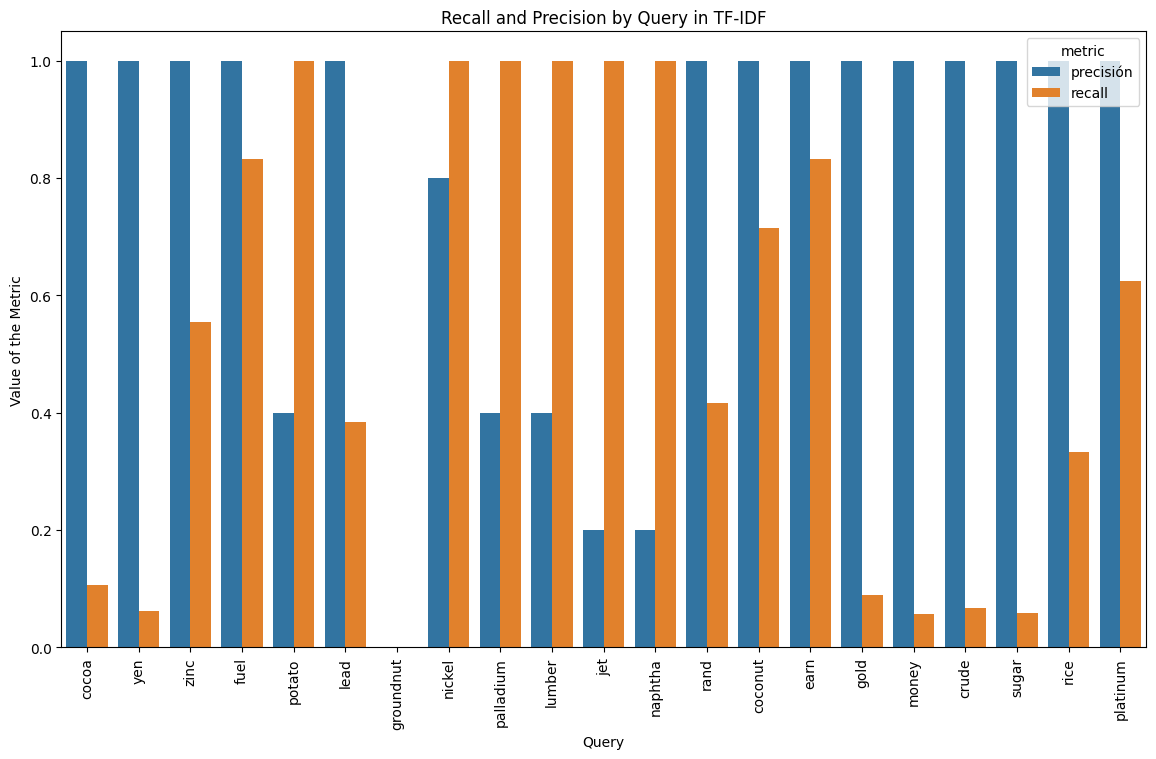

In [70]:
# Derretir el DataFrame para tener las métricas en formato largo
df_melted_tfidf = df_metricas.melt(id_vars='query', value_vars=['precisión', 'recall'], var_name='metric', value_name='value')

# Crear la figura
plt.figure(figsize=(14, 8))

# Crear el gráfico de barras
sns.barplot(x='query', y='value', hue='metric', data=df_melted_tfidf)

# Configurar el gráfico
plt.xticks(rotation=90)  # Rotar las etiquetas del eje x para que se vean mejor
plt.title('Recall and Precision by Query in TF-IDF')  # Título del gráfico
plt.xlabel('Query')  # Etiqueta del eje X
plt.ylabel('Value of the Metric')  # Etiqueta del eje Y

# Mostrar el gráfico
plt.show()

#### 2.6.3.   Comparar el rendimiento de diferentes configuraciones del sistema.